In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from avp_pckg.DataFrame import AvPdataFrame 
from avp_pckg.avp_model_selection import cross_validate_pipe
from avp_pckg.avp_model_selection import cross_validate_IsBadBuy
from avp_pckg.avp_model_selection import plot_scores, print_scores, wheels_type_split
from avp_pckg.IsBadBuy_functions import load_features, calc_price_diff
from avp_pckg.avp_model_selection import PrepareColsBase, PrepareColsTEncoder
from avp_pckg.TransformerCols import IsBadBuyTransformer, LinearImputer

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import classification_report, f1_score # accuracy_score, recall_score, precision_score

%load_ext autoreload
%autoreload 2


avp_pckg init file


# Construction of a base models. Strongly correlated prise columns changed on its differences.  
- tree
- random forest
- logistic regression

## 1. Load data as train and test sets.

In [45]:
cols_cat = [ 
            'Auction', 
            'VehicleAge',  
            'WheelType',
#           'BYRNO', 
           'VNZIP1', # info byer
#           'Make', 
           'Model', 
#           'Trim', 
#           'SubModel', # info model
           'Color',  
#           'PRIMEUNIT', 
           'AUCGUART', 
#           'Size', #  info model, low information
            ##
   #        'IsOnlineSale', 'Transmission', # low information
    #       'Nationality',  # redundant information
    #      'TopThreeAmericanName', 'VNST', 'VehYear', 'WheelTypeID' # redundant information
            ] 

cols_num = [
       #      'VehicleAge',
            'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
            'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
            'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
            'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 
       #     'VehOdo', 
            'VehBCost', 
       #     'WarrantyCost'
            ]

cols_dict={
           'VehBCost':[3_500, 5_000, 7_000, 12_000],
        #   'VehOdo': [50_000, 75_000, 100_000],             
             #'RetailClean': [-5_000, -1200, -150, 450, ], # wheels
            #  'RetailClean': [-2_000, -1200, -450, -100, 100, 450, ], # no wheels
            #   'AcqClean': [300, 800, 1000, 2000, 3000],  # wheels
            # # 'AcqClean': [1000, 2000, 3700], # no Wheels
            #    'AcqRetail': [200, 650, 1_200], # wheels
            #    'AcqAuc': [400, 600, 1_100] # wheels
             }

cols_MCA=[
#2          ('Make', 'Model', 'Trim',), 
# 3           ('BYRNO', 'VNZIP1'), 
# 1         ('Color', 'Size', 'PRIMEUNIT', 'AUCGUART',),
#0          ('VehicleAge' , 'VehBCost_avp')
          ]


In [56]:
### loaded only selected featurs in cols_cat and cols_num! 
# Other features (timedate column) remooved during loading.
#  NaN filing: cols_cat = 'empty', cols_num = 0. 
fname = 'data\\features_train.csv'
X_train = load_features(fname=fname, cols_cat=cols_cat, cols_num=cols_num)
tname = 'data\\target_train.csv'
y_train = features = pd.read_csv(tname, index_col='RefId')

fname = 'data\\features_test.csv'
X_test = load_features(fname=fname, cols_cat=cols_cat, cols_num=cols_num)
tname = 'data\\target_test.csv'
y_test = features = pd.read_csv(tname, index_col='RefId')
X_test.head()
X_test.columns


Index(['Auction', 'VehicleAge', 'Model', 'Color', 'WheelType', 'VehOdo',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
       'AUCGUART', 'VNZIP1', 'VehBCost'],
      dtype='object')

In [92]:
# ### check of IsBadBuyTransformer
# from avp_pckg.TransformerCols import IsBadBuyTransformer

# #### price imputer + price differences
# prepare_cols = IsBadBuyTransformer(cols_cat=cols_cat,
#                                    cols_num=cols_num,
#                                    num_to_cat_dict = cols_dict,
#                                    impute=False,
#                                    diff = True,
#                                    target_encoder = True,
#                                    cols_MCA_list=cols_MCA,
#                                    )
# df = prepare_cols.fit_transform(X_train, y_train)  # before use switch off onehotencoder 
# df.head()


echo transform MCA list itteration ('VehicleAge', 'VehBCost_avp')
Index(['Auction', 'VehicleAge', 'Make', 'Model', 'Trim', 'SubModel', 'Color',
       'WheelType', 'VehOdo', 'Size', 'PRIMEUNIT', 'AUCGUART', 'BYRNO',
       'VNZIP1', 'WarrantyCost', 'RetailClean', 'AcqClean', 'AcqRetail',
       'AcqAuc', 'VehBCost_avp', 'VehicleAge*VehBCost_avp'],
      dtype='object')
['Model', 'PRIMEUNIT', 'Color', 'BYRNO', 'AUCGUART', 'Make', 'WheelType', 'VNZIP1', 'SubModel', 'Size', 'Auction', 'VehicleAge*VehBCost_avp', 'Trim']
transformator echo
echo transform MCA list itteration ('VehicleAge', 'VehBCost_avp')
Index(['Auction', 'VehicleAge', 'Make', 'Model', 'Trim', 'SubModel', 'Color',
       'WheelType', 'VehOdo', 'Size', 'PRIMEUNIT', 'AUCGUART', 'BYRNO',
       'VNZIP1', 'WarrantyCost', 'RetailClean', 'AcqClean', 'AcqRetail',
       'AcqAuc', 'VehBCost_avp', 'VehicleAge*VehBCost_avp'],
      dtype='object')


,Auction,WheelType,VehOdo,Size,PRIMEUNIT,AUCGUART,WarrantyCost,RetailClean,AcqClean,AcqRetail,AcqAuc,Model_avp,Color_avp,BYRNO_avp,Make_avp,VNZIP1_avp,SubModel_avp,VehicleAge*VehBCost_avp_avp,Trim_avp
RefId,,,,,,,,,,,,,,,,,,,
71987,ADESA,Alloy,61897,CROSSOVER,empty,empty,1606,244.0,1145.0,1448.0,1341.0,Model_B05,Color_D15,BYRNO_D15,Make_D15,VNZIP1_C20,SubModel_C10,VehicleAge*VehBCost_avp_D10,Trim_E15
68623,ADESA,Covers,65047,MEDIUM,empty,empty,1118,221.0,3742.0,1260.0,1124.0,Model_C15,Color_E15,BYRNO_C10,Make_D15,VNZIP1_C20,SubModel_E15,VehicleAge*VehBCost_avp_D10,Trim_E15
10478,MANHEIM,Covers,66007,LARGE,empty,empty,1703,-334.0,3528.0,1396.0,1151.0,Model_D10,Color_D15,BYRNO_D15,Make_E10,VNZIP1_D15,SubModel_D10,VehicleAge*VehBCost_avp_D10,Trim_D10
63153,MANHEIM,Alloy,92422,MEDIUM SUV,empty,empty,1630,-155.0,4289.0,1662.0,1999.0,Model_C15,Color_E15,BYRNO_C15,Make_E10,VNZIP1_D10,SubModel_C15,VehicleAge*VehBCost_avp_D10,Trim_D10
60462,ADESA,Alloy,72583,LARGE SUV,empty,empty,1923,-1847.0,1227.0,1840.0,1704.0,Model_B05,Color_D15,BYRNO_D20,Make_E10,VNZIP1_C20,SubModel_B15,VehicleAge*VehBCost_avp_D20,Trim_D10


## 2. Tree-model
cross-validate 

cross_validate echo: parameter value =  3
cross_validate echo: parameter value =  4
cross_validate echo: parameter value =  5
cross_validate echo: parameter value =  6
cross_validate echo: parameter value =  7
cross_validate echo: parameter value =  8
cross_validate echo: parameter value =  9
cross_validate echo: parameter value =  10
| index  | f1_mean | f1_std | precission |
|      3 |   0.354 | 0.0062 |      0.295 |
|      4 |   0.362 | 0.0066 |      0.309 |
|      5 |   0.378 | 0.0085 |       0.34 |
|      6 |   0.376 | 0.0106 |      0.335 |
|      7 |   0.352 | 0.0332 |      0.292 |
|      8 |   0.348 | 0.0244 |      0.276 |
|      9 |   0.323 |  0.027 |      0.226 |
|     10 |   0.336 |  0.024 |      0.243 |


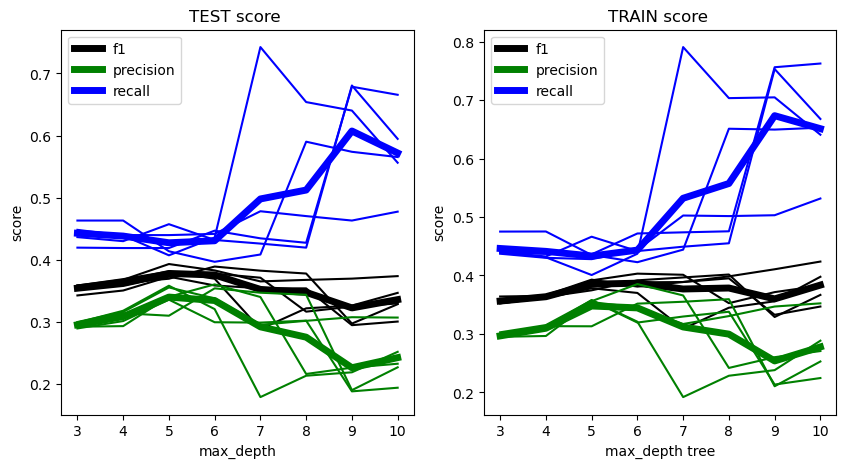

In [47]:
# execution time= 34 s 
param_name ='max_depth'
param_range = [3, 4, 5, 6, 7, 8, 9, 10,]# 12, 14, 16, 18,]
score_dict = cross_validate_IsBadBuy(X=X_train,
                                y=y_train,
                                cols_cat=cols_cat,
                                cols_num=cols_num,
                                param_name=param_name,
                                param_range= param_range,
                                num_to_cat_dict = cols_dict,
                                cv=5, 
                                max_cat=25,
                                estimator_name='tree',
                                impute=False,
                                diff = True,
                                target_encoder = True,
                                cols_MCA_list=cols_MCA,
                                n_jobs=-1,
                                )

plot_scores(score_dict, param_name='max_depth tree')
print_scores(score_dict)


Cross-Validation improvments steps Tree classifier
| model | parameter | f1_cv | f1_std | precision_  | comments
|---|---|---|---|---|---|
| Base Tree | depth=4 | 0.376 | 0.010 | 0.315 | 
| + Price diff | depth=5 | 0.356 | 0.015 | 0.279 |
| + Target Encoder| depth=7 | 0.369 | 0.009 | 0.306 |
| + impute Price | depth=7 | 0.369 | 0.009 | 0.306 | off (time)
| + skip Redundent |  depth=7 | 0.367 | 0.007 | 0.302 |
| + skip low info. |  depth=7 | 0.367 | 0.007 | 0.302 |
| + all num to cat | depth=5 | 0.361 | 0.0032 | 0.297 | off (f1)
| + 2 num to cat | depth=6 |   0.365 |  0.004 | 0.303 | off(see next)
| + 1 num to cat | depth=6 |   0.369 | 0.006 |  0.32 |
| + mearge 1 | depth=  6 |   0.365 | 0.0079 | 0.308 | off
| + mearge 2 | depth=12 |   0.325 | 0.0055 | 0.224 |   off
| + mearge 3 | depth=6 |   0.365 | 0.0086 |  0.315 | off
| + VehAge as num| depth=6 |  0.345 | 0.0124 | 0.242 | off 
| - WorrntyCost | depth= 5 |   0.376 | 0.0092 |      0.335 |
| - 'VehOdo' | depth=5 |   0.377 | 0.0085 |      0.339 |
| - 'Size'   | depth=5 |   0.377 | 0.0084 |      0.339 |
| - 'AUCGUART' | depth= 5 |   0.376 | 0.0089 |      0.335 | off
| - 'PRIMEUNIT' | depth= 5 |   0.377 | 0.0084 |      0.339 |
| - 'Color' | depth=5 |   0.377 | 0.0088 |      0.338 | off
| - 'SubModel'| depth= 5 |   0.377 | 0.0083 |      0.339 |
| - 'Trim' | depth=5 |   0.378 | 0.0086 |      0.339 |
| - 'Model'| depth= 5 |   0.376 | 0.0106 |       0.34 | off
| - 'Make' | depth=5 |   0.378 | 0.0084 |       0.34 |
| - 'VNZIP1' | depth= 5 |   0.376 | 0.0078 |      0.338 | off
| - 'BYRNO' | depth=  5 |   0.378 | 0.0085 |       0.34 |
| - 'WheelType'| 10 |   0.284 | 0.0051 |      0.185| off important!
| - 'VehicleAge'|  6 |   0.374 | 0.0095 |      0.327 | off
| - 'Auction' |   5 |   0.375 | 0.0073 |      0.337 | off
||
||5 |   0.378 | 0.0085 |       0.34 |




## 2. Random Forest
cross-validate 

In [79]:
cols_cat = [ 
            'Auction', 
            'VehicleAge',  
            'WheelType',
           'BYRNO', 
           'VNZIP1', # info byer
           'Make', 
           'Model', 
#           'Trim', 
#           'SubModel', # info model
           'Color',  
#           'PRIMEUNIT', 
           'AUCGUART', 
#           'Size', #  info model, low information
            ##
   #        'IsOnlineSale', 'Transmission', # low information
    #       'Nationality',  # redundant information
    #      'TopThreeAmericanName', 'VNST', 'VehYear', 'WheelTypeID' # redundant information
            ] 

cols_num = [
       #      'VehicleAge',
            'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
            'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
            'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
            'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 
            'VehOdo', 
            'VehBCost', 
#            'WarrantyCost'
            ]

cols_dict={
           'VehBCost':[3_500, 5_000, 7_000, 12_000],
    #       'VehOdo': [50_000, 75_000, 100_000],             
             }

fname = 'data\\features_train.csv'
X_train = load_features(fname=fname, cols_cat=cols_cat, cols_num=cols_num)
tname = 'data\\target_train.csv'
y_train = features = pd.read_csv(tname, index_col='RefId')

fname = 'data\\features_test.csv'
X_test = load_features(fname=fname, cols_cat=cols_cat, cols_num=cols_num)
tname = 'data\\target_test.csv'
y_test = features = pd.read_csv(tname, index_col='RefId')
X_test.head()
X_test.columns

Index(['Auction', 'VehicleAge', 'Make', 'Model', 'Color', 'WheelType',
       'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'AUCGUART', 'BYRNO', 'VNZIP1',
       'VehBCost'],
      dtype='object')

cross_validate echo: parameter value =  5
cross_validate echo: parameter value =  6
cross_validate echo: parameter value =  7
cross_validate echo: parameter value =  8
cross_validate echo: parameter value =  9
cross_validate echo: parameter value =  10
cross_validate echo: parameter value =  12
| index  | f1_mean | f1_std | precission |
|      5 |   0.362 | 0.0067 |      0.262 |
|      6 |   0.367 | 0.0056 |      0.269 |
|      7 |    0.37 | 0.0069 |      0.271 |
|      8 |   0.376 | 0.0041 |      0.278 |
|      9 |   0.378 | 0.0076 |      0.282 |
|     10 |   0.384 | 0.0066 |      0.293 |
|     12 |   0.391 | 0.0064 |      0.311 |


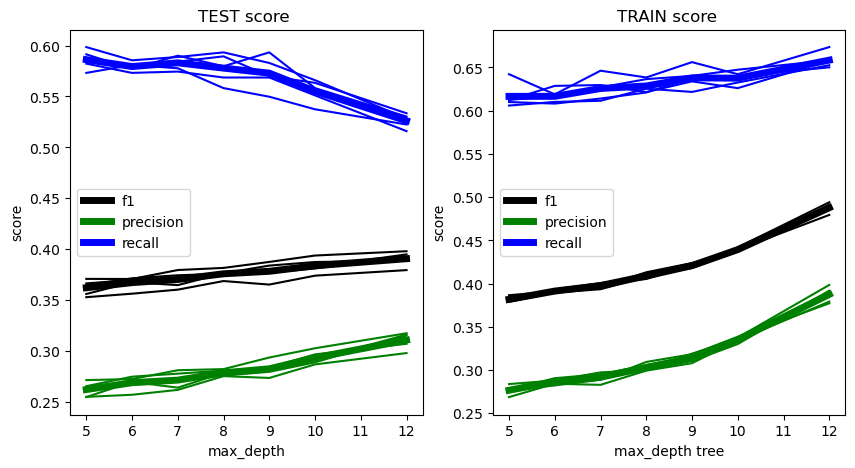

In [80]:
# execution time= 2m 12s 
param_name ='max_depth'
param_range = [ 5, 6, 7, 8, 9, 10, 12,]# 14, 16, 18,]
score_dict = cross_validate_IsBadBuy(X=X_train,
                                y=y_train,
                                cols_cat=cols_cat,
                                cols_num=cols_num,
                                param_name=param_name,
                                param_range= param_range,
                                num_to_cat_dict = cols_dict,
                                cv=5, 
                                max_cat=25,
                                estimator_name='forest',
                                impute=False,
                                diff = True,
                                target_encoder = True,
                                cols_MCA_list=cols_MCA,
                                n_jobs=-1,
                                )

plot_scores(score_dict, param_name='max_depth tree')
print_scores(score_dict)



Cross-Validation improvments steps forest classifier
| model | depth | f1_cv | f1_std | precision_  | comments
|---|---|---|---|---|---|
| cols Tree |  10 |   0.376 | 0.0065 | 0.285 |
| + impute | 10 |   0.374 | 0.0047 |      0.283 | off
| + 'VehOdo'| 10 |    0.38 | 0.0061 |       0.29 |   
| + 'WarrantyCost' | 10 |   0.381 | 0.0063 |      0.291 | off
| + 'BYRNO' |  10 |    0.38 | 0.0049 |      0.288 |
| + 'Make' | 8 |   0.375 | 0.0044 |      0.278 |
| + 'Trim' | 8 |   0.373 |  0.006 |      0.273 | off
| + 'SubModel'| 8 | 0.37 | 0.0064 |      0.273 | off
| - 'Color' |  8 |   0.375 | 0.0081 |      0.278 | off
| + 'PRIMEUNIT' | 8 |   0.373 | 0.0048 |      0.273 | off
| 'VehBCost' num |  8 |   0.371 |  0.007 |      0.273 | off
| 'VehOdo' cat | 8 |   0.373 | 0.0045 |      0.273 | off
||
||  8 |   0.376 | 0.0041 |      0.278 |



## 2. Logistic Regresion
cross-validate 

In [102]:
cols_cat = [ 
            'Auction', 
 #           'VehicleAge',  
            'WheelType',
           'BYRNO', 
           'VNZIP1', # info byer
           'Make', 
           'Model', 
#           'Trim', 
           'SubModel', # info model
           'Color',  
#           'PRIMEUNIT', 
           'AUCGUART', 
#           'Size', #  info model, low information
            ##
   #        'IsOnlineSale', 'Transmission', # low information
    #       'Nationality',  # redundant information
    #      'TopThreeAmericanName', 'VNST', 'VehYear', 'WheelTypeID' # redundant information
            ] 

cols_num = [
             'VehicleAge',
            'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
            'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
            'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
            'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 
            'VehOdo', 
            'VehBCost', 
#            'WarrantyCost'
            ]

cols_dict={
           'VehBCost':[3_500, 5_000, 7_000, 12_000],
    #       'VehOdo': [50_000, 75_000, 100_000],             
             }

fname = 'data\\features_train.csv'
X_train = load_features(fname=fname, cols_cat=cols_cat, cols_num=cols_num)
tname = 'data\\target_train.csv'
y_train = features = pd.read_csv(tname, index_col='RefId')

fname = 'data\\features_test.csv'
X_test = load_features(fname=fname, cols_cat=cols_cat, cols_num=cols_num)
tname = 'data\\target_test.csv'
y_test = features = pd.read_csv(tname, index_col='RefId')
X_test.head()
X_test.columns

Index(['Auction', 'VehicleAge', 'Make', 'Model', 'SubModel', 'Color',
       'WheelType', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'AUCGUART', 'BYRNO', 'VNZIP1',
       'VehBCost'],
      dtype='object')

cross_validate echo: parameter value =  0.001
cross_validate echo: parameter value =  0.002
cross_validate echo: parameter value =  0.004
cross_validate echo: parameter value =  0.01
cross_validate echo: parameter value =  0.02
cross_validate echo: parameter value =  0.04
cross_validate echo: parameter value =  0.1
cross_validate echo: parameter value =  1
| index  | f1_mean | f1_std | precission |
|  0.001 |   0.361 | 0.0036 |      0.252 |
|  0.002 |   0.368 | 0.0028 |       0.26 |
|  0.004 |   0.369 | 0.0031 |      0.263 |
|   0.01 |    0.37 | 0.0019 |      0.265 |
|   0.02 |   0.369 | 0.0026 |      0.264 |
|   0.04 |   0.368 |  0.002 |      0.264 |
|    0.1 |   0.366 | 0.0023 |      0.263 |
|    1.0 |   0.361 | 0.0026 |       0.26 |


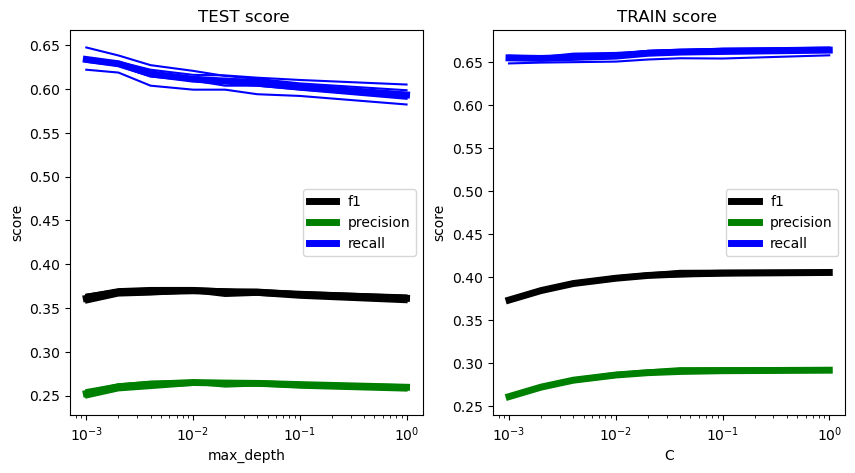

In [103]:
param_name ='C'
param_range = [0.001, 0.002, 0.004, 0.01, 0.02, 0.04, 0.1, 1,]
score_dict = cross_validate_IsBadBuy(X=X_train,
                                y=y_train,
                                cols_cat=cols_cat,
                                cols_num=cols_num,
                                param_name=param_name,
                                param_range= param_range,
                                num_to_cat_dict = cols_dict,
                                cv=5, 
                                max_cat=25,
                                estimator_name='logistic',
                                impute=False,
                                diff = True,
                                target_encoder = True,
                                cols_MCA_list=cols_MCA,
                                n_jobs=-1,
                                )

plot_scores(score_dict, param_name=param_name, xlog=True)
print_scores(score_dict)



Cross-Validation improvments steps logistic regression classifier
| model | C | f1_cv | f1_std | precision_  | comments
|---|---|---|---|---|---|
| cols forest |  0.004 |    0.37 | 0.0032 |      0.263 |
| 'VehBCost' num | 0.02 |   0.367 |  0.002 |      0.262 | off
| + 'WarrantyCost' |  0.004 |    0.37 | 0.0045 |      0.263 | off
| - 'BYRNO' | 0.01 |   0.367 | 0.0019 |      0.262 | off  
| - 'Make' |  0.004 |   0.369 |  0.003 |      0.263 | off
| - 'Model' |   0.04 |   0.366 | 0.0048 |      0.261 | off
| + 'SubModel'|   0.01 |   0.369 | 0.0021 |      0.264 |
| 'VehicleAge' num | 0.01 |    0.37 | 0.0019 |      0.265 |
| + impute | 0.01 |   0.369 | 0.0021 |      0.265 | off
| - target_encoder |  0.02 |   0.374 | 0.0075 |      0.267 | off (std)
| + 'Size' | 0.01 |   0.369 |  0.004 |      0.264 | off
| |   0.01 |    0.37 | 0.0019 |      0.265 |


Cross-Validation with price differencies
| model | parameter | f1_cv | precision  | recall | f1-score | support |
|---|---|---|---|---|---|---|
| Tree | depth=5 |   0.378 |- |- | - | - |
| Forest | depth=8 |   0.376 | - | - |- | - |
| LogReg | C=0.01 | 0.37 | - | - |- | - |


# Predictoins

- load data

In [127]:
cols_cat = [ 
            'Auction', 
            'VehicleAge',  
            'WheelType',
           'BYRNO', 
           'VNZIP1', # info byer
           'Make', 
           'Model', 
           'Trim', 
           'SubModel', # info model
           'Color',  
           'PRIMEUNIT', 
           'AUCGUART', 
           'Size', #  info model, low information
            ##
           'IsOnlineSale', 'Transmission', # low information
           'Nationality',  # redundant information
          'TopThreeAmericanName', 'VNST', 'VehYear', 'WheelTypeID' # redundant information
            ] 

cols_num = [

            'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
            'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
            'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
            'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 
            'VehOdo', 
            'VehBCost', 
            'WarrantyCost'
            ]

fname = 'data\\features_train.csv'
X_train = load_features(fname=fname, cols_cat=cols_cat, cols_num=cols_num)
tname = 'data\\target_train.csv'
y_train = pd.read_csv(tname, index_col='RefId')

fname = 'data\\features_test.csv'
X_test = load_features(fname=fname, cols_cat=cols_cat, cols_num=cols_num)
tname = 'data\\target_test.csv'
y_test = pd.read_csv(tname, index_col='RefId')
X_test.head()
X_test.columns

d:\StackFuel_2024\course04_portfolio\Portfolio2024\avp_pckg\IsBadBuy_functions.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1.0' '2.0' '2.0' ... '1.0' '1.0' '2.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  features.loc[:, 'WheelTypeID'] = features['WheelTypeID'].astype(str)
d:\StackFuel_2024\course04_portfolio\Portfolio2024\avp_pckg\IsBadBuy_functions.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2.0' '3.0' '1.0' ... '1.0' '2.0' '2.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  features.loc[:, 'WheelTypeID'] = features['WheelTypeID'].astype(str)


Index(['Auction', 'VehYear', 'VehicleAge', 'Make', 'Model', 'Trim', 'SubModel',
       'Color', 'Transmission', 'WheelTypeID', 'WheelType', 'VehOdo',
       'Nationality', 'Size', 'TopThreeAmericanName',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
       'PRIMEUNIT', 'AUCGUART', 'BYRNO', 'VNZIP1', 'VNST', 'VehBCost',
       'IsOnlineSale', 'WarrantyCost'],
      dtype='object')

In [128]:
y_train.columns

Index(['IsBadBuy'], dtype='object')

### Tree model predict

In [134]:
cols_cat_tree = [ 
            'Auction', 'VehicleAge',  'WheelType', 'VNZIP1', 'Model', 'Color', 'AUCGUART', 
            ] 

cols_num_tree = [
            'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
            'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
            'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
            'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 
            'VehBCost', 
            ]


cols_dict={'VehBCost':[3_500, 5_000, 7_000, 12_000], }
### Tree model #########################################################
pipe_tree = Pipeline(steps=[
('prepare_cols', IsBadBuyTransformer(cols_cat=cols_cat_tree, 
                         cols_num=cols_num_tree, 
                         num_to_cat_dict=cols_dict,
                         max_cat=25,
                         impute=False,
                         diff = True,
                         target_encoder = True,
                         )
 ),
('model', DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=5))
])

pipe_tree.fit(X_train, y_train) 

pred_tree = pipe_tree.predict(X_test)
df_pred_tree = pd.DataFrame(pred_tree, index=X_test.index)
df_pred_tree.columns = ['tree']

report = classification_report(y_test, pred_tree)
print('tree report: \n', report)
print('tree pred.sum():', pred_tree.sum())



transformator echo
transformator echo
tree report: 
               precision    recall  f1-score   support

           0       0.92      0.89      0.90      9657
           1       0.34      0.43      0.38      1291

    accuracy                           0.83     10948
   macro avg       0.63      0.66      0.64     10948
weighted avg       0.85      0.83      0.84     10948

tree pred.sum(): 1647


final
| model | parameter | f1_cv | precision  | recall | f1-score | support |
|---|---|---|---|---|---|---|
| Tree | depth=5 |   0.378 |0.34 |0.43 |0.38 | 1647 |
| Forest | depth=8 |   0.376 | | |- | - |
| LogReg | C=0.01 | 0.37 | - | - |- | - |

In [138]:
cols_cat_forest = [ 'Auction', 'VehicleAge',  'WheelType', 'BYRNO', 
           'VNZIP1', 'Make',  'Model', 'Color',  'AUCGUART',   ] 

cols_num_forest = [
            'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
            'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
            'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
            'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 
            'VehOdo', 'VehBCost', 
            ]
### Forest model #########################################################
pipe_forest = Pipeline(steps=[
('base', IsBadBuyTransformer(cols_cat=cols_cat_forest, 
                         cols_num=cols_num_forest, 
                         num_to_cat_dict=cols_dict,
                         max_cat=25,
                         impute=False,
                         diff = True,
                         target_encoder = True,
                         )
 ),
('model', RandomForestClassifier(class_weight='balanced', 
                                 random_state=42, 
                                 max_depth=8))
])

pipe_forest.fit(X_train, y_train)
pred_forest = pipe_forest.predict(X_test)
df_pred_forest = pd.DataFrame(pred_forest, index=X_test.index)
df_pred_forest.columns = ['forest']


report = classification_report(y_test, pred_forest)
print('forest report: \n', report)
print('forest pred.sum():', pred_forest.sum())


transformator echo


c:\myProgramms\anaconda3\envs\env_pp\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


transformator echo
forest report: 
               precision    recall  f1-score   support

           0       0.93      0.79      0.86      9657
           1       0.27      0.58      0.37      1291

    accuracy                           0.77     10948
   macro avg       0.60      0.68      0.61     10948
weighted avg       0.86      0.77      0.80     10948

forest pred.sum(): 2747


final
| model | parameter | f1_cv | precision  | recall | f1-score | support |
|---|---|---|---|---|---|---|
| Tree | depth=5 |   0.378 |0.34 |0.43 |0.38 | 1647 |
| Forest | depth=8 |   0.376 | 0.27 |0.58 |0.37 | 2747 |
| LogReg | C=0.01 | 0.37 | - | - |- | - |

In [140]:
cols_cat_reg = [ 'Auction', 'WheelType', 'BYRNO', 'VNZIP1',  'Make', 
           'Model',  'SubModel', 'Color',   'AUCGUART',     ] 

cols_num_reg = [
             'VehicleAge',
            'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
            'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
            'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
            'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 
            'VehOdo', 'VehBCost', 
            ]

pipe_reg = Pipeline(steps=[
('preprocessing',IsBadBuyTransformer(cols_cat=cols_cat_reg, 
                         cols_num=cols_num_reg, 
                         num_to_cat_dict=cols_dict,
                         max_cat=25,
                         impute=False,
                         diff = True,
                         target_encoder = True,
                         )
 ),
('model', LogisticRegression(class_weight='balanced', random_state=42, C=0.01))
])

pipe_reg.fit(X_train, y_train)
pred_reg = pipe_reg.predict(X_test)
df_pred_reg = pd.DataFrame(pred_reg, index=X_test.index)
df_pred_reg.columns = ['logistic']

report = classification_report(y_test, pred_reg)
print('regression report: \n', report)
print('logistig pred.sum():', pred_reg.sum())



transformator echo
transformator echo
regression report: 
               precision    recall  f1-score   support

           0       0.94      0.75      0.84      9657
           1       0.25      0.62      0.36      1291

    accuracy                           0.74     10948
   macro avg       0.59      0.69      0.60     10948
weighted avg       0.86      0.74      0.78     10948

logistig pred.sum(): 3175


c:\myProgramms\anaconda3\envs\env_pp\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


final
| model | parameter | f1_cv | precision  | recall | f1-score | support |
|---|---|---|---|---|---|---|
| Tree | depth=5 |   0.378 |0.34 |0.43 |0.38 | 1647 |
| Forest | depth=8 |   0.376 | 0.27 |0.58 |0.37 | 2747 |
| LogReg | C=0.01 | 0.37 | 0.25 | 0.62 | 0.36 | 3175 |

Cross-Validation with price differencies
| model | parameter | f1_cv | precision  | recall | f1-score | support |
|---|---|---|---|---|---|---|
| Tree | depth=5 | 0.356 |0.31 |0.46 | 0.37 | 1945 |
| Forest | depth=7 |0.379 | 0.27  | 0.56 |0.37| 2636 |
| LogReg | C=0.01 | 0.375 |  0.26 | 0.63 |0.36 | 3173 |


## Ensamble

In [141]:
df_pred = pd.concat([df_pred_tree, df_pred_forest, df_pred_reg], axis=1)
df_pred.loc[:, 'sum'] = df_pred['tree'] + df_pred['forest'] + df_pred['logistic']
df_pred.loc[:, 'result1'] = round((df_pred['sum']+1)/3).astype(int)
df_pred.loc[:, 'result2'] = round((df_pred['sum']+0)/3).astype(int)
df_pred.loc[:, 'result3'] = round((df_pred['sum']-1)/3).astype(int)

display(df_pred.head())
print(df_pred.sum())

,tree,forest,logistic,sum,result1,result2,result3
RefId,,,,,,,
27871,1,1,1,3,1,1,1
51624,0,0,1,1,1,0,0
31955,0,0,0,0,0,0,0
12344,0,0,0,0,0,0,0
68965,0,0,0,0,0,0,0


tree        1647
forest      2747
logistic    3175
sum         7569
result1     3687
result2     2510
result3     1372
dtype: int64


In [142]:
report = classification_report(y_test, df_pred['result3'])
print('result3 report: \n', report)

# report = classification_report(y_test, df_pred['result2'])
# print('result2: \n', report)

report = classification_report(y_test, df_pred['result1'])
print('result1: \n', report)

result3 report: 
               precision    recall  f1-score   support

           0       0.92      0.91      0.92      9657
           1       0.38      0.41      0.40      1291

    accuracy                           0.85     10948
   macro avg       0.65      0.66      0.66     10948
weighted avg       0.86      0.85      0.85     10948

result1: 
               precision    recall  f1-score   support

           0       0.94      0.71      0.81      9657
           1       0.23      0.67      0.35      1291

    accuracy                           0.70     10948
   macro avg       0.59      0.69      0.58     10948
weighted avg       0.86      0.70      0.75     10948



final
| model | parameter | f1_cv | precision  | recall | f1-score | support.sum() |
|---|---|---|---|---|---|---|
| Tree | depth=5 |   0.378 |0.34 |0.43 |0.38 | 1647 |
| Forest | depth=8 |   0.376 | 0.27 |0.58 |0.37 | 2747 |
| LogReg | C=0.01 | 0.37 | 0.25 | 0.62 | 0.36 | 3175 |
|Ensamble prec| - |- |  0.38|  0.41|0.40| 1372|
|Ensamble recall| - |- |0.23|0.67|0.35|3873|

Cross-Validation with price differencies
| model | parameter | f1_cv | precision  | recall | f1-score | pred.sum() |
|---|---|---|---|---|---|---|
| Tree | depth=5 | 0.356 |0.31 |0.46 | 0.37 | 1945 |
| Forest | depth=7 |0.379 | 0.27  | 0.56 | 0.37 | 2636 |
| LogReg | C=0.01 | 0.375 |  0.26 | 0.63 | 0.36 | 3173 |
|Ensamble| - |- | 0.40 | 0.41 | 0.40 | 1343 |

final
| model | parameter | f1_cv | precision  | recall | f1-score | pred.sum() |
|---|---|---|---|---|---|---|
| Tree | depth=5 |   0.378 |0.34 |0.43 |0.38 | 1647 |
| Forest | depth=8 |   0.376 | 0.27 |0.58 |0.37 | 2747 |
| LogReg | C=0.01 | 0.37 | 0.25 | 0.62 | 0.36 | 3175 |
|Ensamble | - |- |  0.38|  0.41|0.40| 1372|

Cross-Validation improvments steps Tree classifier
| model | depth | f1_cv | f1_std | precision_  | 
|---|---|---|---|---|
| Base Tree | 4 | 0.376 | 0.010 | 0.315 | 
| + Price diff | 5 | 0.356 | 0.015 | 0.279 |
| + Target Encoder| 7 | 0.369 | 0.009 | 0.306 |
| + skip redundant |  7 | 0.367 | 0.007 | 0.302 |
| + skip low info. |  7 | 0.367 | 0.007 | 0.302 |
| + 1 num to cat | 6 |   0.369 | 0.006 |  0.32 |
| - WorrntyCost |  5 |   0.376 | 0.0092 |      0.335 |
| - 'VehOdo' | 5 |   0.377 | 0.0085 |      0.339 |
| - 'SubModel'| 5 |   0.377 | 0.0083 |      0.339 |
| - 'Trim' | 5 |   0.378 | 0.0086 |      0.339 |
| - 'Make' | 5 |   0.378 | 0.0084 |       0.34 |
| - 'BYRNO' | 5 |   0.378 | 0.0085 |       0.34 |
